# Comparison with dit

In this notebook we make some basic comparisons between embo and [dit](https://pypi.org/project/dit) [[James et al 2018]](https://doi.org/10.21105/joss.00738). The comparison has two goals:
1. to show that the IB solutions found by the two packages are roughly the same in some example cases, as an extra correctness check for embo;
2. to compare the time taken by the two packages to find these solutions. Dit provides a broad, general-purpose toolset for doing information theory with discrete random variables, while embo has the advantage of being a simpler and more specialized tool. Here we show that as a result embo is much faster.

## Preliminaries
After the usual imports and some plotting configuration, we define four probability distributions that we will use for our tests. These have different dimensionalities ($|X|\times|Y|$): one is $2\times 2$, one $3\times 3$, one $4\times 4$ and one $5\times 5$. The $3\times 3$ case is the example used in the documentation for the IB functionality in dit at the time of writing (dit version 1.2.3).

In [22]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import pickle


from embo import InformationBottleneck
import dit
from dit.rate_distortion import IBCurve

plt.style.use('style.mplstyle')

palette = [item['color'] for item in plt.rcParams['axes.prop_cycle']]

colors = {
    'embo' : palette[2],
    'dit/sp' : palette[1],
    'dit/ba' : palette[3]
}

tool_names = list(colors.keys())

# set up the same probability distributions in two different formats, one embo-friendly, the other dit-friendly
dist = {
    'embo' : [
        np.array([
            [0.1, 0.4],
            [0.35, 0.15]]),
        np.array([
            [0.2, 0, 0.2],
            [0, 0, 0.2],
            [0, 0.2, 0.2]]),
        np.array([
            [0.1, 0.1, 0, 0.1],
            [0.05, 0, 0.05, 0.1],
            [0.02, 0.03, 0.25, 0.1],
            [0.03, 0.02, 0., 0.05]]),
        np.array([
            [0.03, 0.07, 0, 0.1, 0.1],
            [0.025, 0, 0.05, 0.1, 0],
            [0.02, 0, 0.05, 0.05, 0.05],
            [0.01, 0.02, 0., 0.05, 0.02],
            [0.025, 0.03, 0.1, 0.1, 0]])
]}
dist['dit'] = [dit.Distribution.from_ndarray(d) for d in dist['embo']]

# set up common configurations for the algorithms
numbeta = 101
maxbeta = 10
alpha = 1
tool_names = ['embo', 'dit/sp']

# prepare data format for uniform access
results = {
    tool : {
        'ix' : [],
        'iy' : [],
        'beta' : [],
        'ixy' : [],
        'hx' : [],
        'time' : [],
        'dimensionality' : []
    } for tool in tool_names
}

## Running the bottleneck
We start by computing the IB with embo. Since embo is very fast, we could (and perhaps should) compute the time it takes to find a solution by averaging over multiple run. However we don't do it for convenience, as it would take too long to do the same for dit and we want to keep the way we store the timing and IB results as homogeneous as possible.

Note that embo can optionally parallelize the computation of the IB, by finding the solution for different values of $\beta$ using different processes. This can help a lot in decreasing computation time. However, the problems we use in this notebook are so simple that it is not worth using this feature, so we use a single process here. We do not use larger or more difficult problems because these are already pretty challenging to solve for dit.

In [23]:
# Run bottleneck with Embo
for k, d in enumerate(dist['embo']):
    t = %timeit -o -r1 -n1 eb = InformationBottleneck(pxy=d, numbeta=numbeta, maxbeta=maxbeta, processes=1, alpha=alpha);\
    eb.get_bottleneck(return_entropies=True);\
    results['embo']['ix'].append(eb.h_m);\
    results['embo']['iy'].append(eb.i_y);\
    results['embo']['beta'].append(eb.beta);\
    results['embo']['ixy'].append(eb.mixy);\
    results['embo']['hx'].append(eb.hx)
    results['embo']['time'].append(t)
    results['embo']['dimensionality'].append(d.size)

302 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
252 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
264 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
321 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now we can solve the same IB problems with dit. Dit actually implements two different algorithms for the IB: one is the standard Blahut-Arimoto algorithm, used in the original IB paper and also internally by embo. The other uses `scipy.optimize`, and is the default one for dit. Below we report results and comparisons for both algorithms; we indicate them as `dit/ba` and `dit/sp` respectively. We note that a bug in dit prevents us from using the BA algorithm on the smallest of our benchmark probability distributions.

In [24]:
# Run bottleneck with dit
for method in ['sp']:
    tool = f"dit/{method}"
    print(f"===={tool}====")
    for k, d in enumerate(dist['dit']):
        try:
            t = %timeit -o -r1 -n1 ib = IBCurve(d, method=method, beta_num=numbeta, beta_max=maxbeta, alpha=alpha);\
            results[tool]['ix'].append(ib.complexities);\
            results[tool]['iy'].append(ib.relevances);\
            results[tool]['beta'].append(ib.betas);\
            results[tool]['ixy'].append(ib._max_relevance);\
            results[tool]['hx'].append(ib._max_complexity)
            results[tool]['time'].append(t)
            results[tool]['dimensionality'].append(dist['embo'][k].size)
        except:
            print(f"Dit crashed with {method} method for distribution n.{k}")
            results[tool]['ix'].append(None)
            results[tool]['iy'].append(None)
            results[tool]['beta'].append(None)
            results[tool]['ixy'].append(None)
            results[tool]['hx'].append(None)
            results[tool]['time'].append(np.NaN)
            results[tool]['dimensionality'].append(dist['embo'][k].size)

====dit/sp====
5.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
24.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
44 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We can summarize the timing data above in a simple plot. We can see that embo solves these simple IB problems in under a second, while dit takes up to 5 minutes (scipy-based algorithm) or 30 minutes (Blahut-Arimoto). These timings have been obtained on a Xeon-based workstation from 2018.

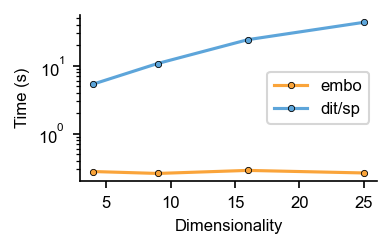

In [10]:
fig, ax = plt.subplots()
for tool in tool_names:
    res = results[tool]
    time = np.array([t if t is np.NaN else t.average for t in res['time']])
    dimensionality = np.array(res['dimensionality'])
    ax.semilogy(dimensionality, time, label=tool, marker='.', color=colors[tool])
ax.set_xlabel('Dimensionality')
ax.set_ylabel('Time (s)')
ax.tick_params(axis='y', which='minor', left=True)
ax.legend()
plt.show()
#fig.savefig(f'embo_vs_dit_timing_alpha{alpha}.png')

We can further analyse the results and compare the quality of the solutions. By inspection of the plots below, it appears that:
1. the solutions found by embo and the scipy-based algorithm in dit mostly match, except for the highest-dimensional distribution where embo discovers an additional portion of the IB bound (but it is likely that this would be found by dit too, for higher values of beta)
2. the Blahut-Arimoto algorithm tends to become unstable at high beta for dit, missing out on part of the IB bound.

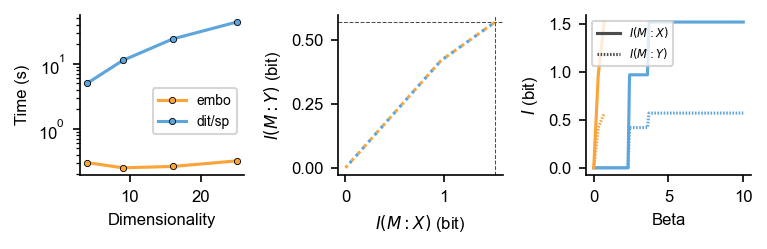

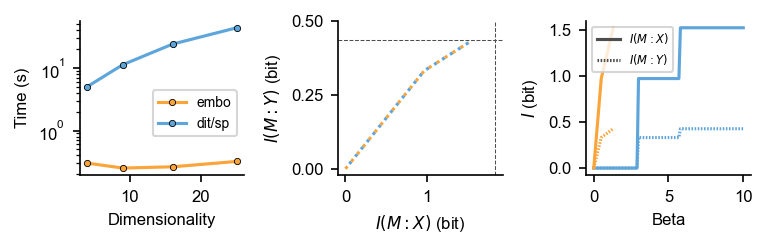

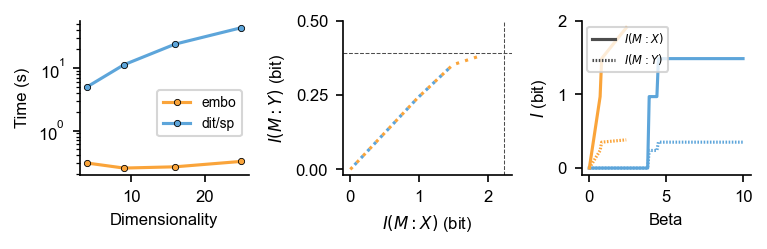

In [25]:
linestyles = {
    'embo' : (0, (1,2)),
    'dit/sp' : (1, (1,2)),
    'dit/ba' : (2, (1,2))
}

for dist_number in [1,2,3]:

    fig, ax = plt.subplots(nrows=1,ncols=3, figsize=np.array((2,1))*plt.rcParams['figure.figsize'], constrained_layout=True)
    legend_loc = 'upper left'
    n_dists_per_setting = int(len(results['embo']['hx'])/4)
    dist_n_absolute = dist_number*n_dists_per_setting
    dist_offset = {'embo' : 0, 'dit/sp' : 0, 'dit/ba' : -(n_dists_per_setting-1)}


    for tool in ['dit/sp', 'embo']:
        dist_n = dist_n_absolute + dist_offset[tool]
        res = results[tool]
        color = colors[tool]
        linestyle = linestyles[tool]
        a = ax[1]
        a.plot(res['ix'][dist_n], res['iy'][dist_n], label=tool, color=color, linestyle=linestyle)
        a.set_ylabel("$I(M:Y)$ (bit)")
        a.set_xlabel("$I(M:X)$ (bit)")
        if tool=='embo':
            a.axhline(res['ixy'][dist_n], linestyle='--', linewidth=0.5, color=palette[0], zorder=-5)
            a.axvline(res['hx'][dist_n], linestyle='--', linewidth=0.5, color=palette[0], zorder=-5)
        a.set_yticks([0., 0.25, 0.5])

        a = ax[2]
        a.plot(res['beta'][dist_n], res['ix'][dist_n], label=tool, color=color)
        a.set_ylabel("$I$ (bit)")
        a.set_xlabel("Beta")

        a = ax[2]
        a.plot(res['beta'][dist_n], res['iy'][dist_n], label=tool, color=color, linestyle=(0,(0.5,0.5)))
        a.set_xlabel("Beta")

    custom_lines = [
        Line2D([0], [0], color=palette[0], linestyle="-"),
        Line2D([0], [0], color=palette[0], linestyle=(0,(0.5,0.5)))
    ]
    ax[2].legend(custom_lines, ["$I(M:X)$", "$I(M:Y)$"], fontsize='x-small', ncol=1, loc='upper left')

    a = ax[0]
    for tool in tool_names:
        res = results[tool]
        time = np.array([t if t is np.NaN else t.average for t in res['time']])
        dimensionality = np.array(res['dimensionality'])
        a.semilogy(dimensionality, time, label=tool, marker='.', color=colors[tool])
    a.set_xlabel('Dimensionality')
    a.set_ylabel('Time (s)')
    a.legend(loc='center right', bbox_to_anchor=(1, 0.4), fontsize='small')
    plt.show()

    #fig.savefig(f'embo_vs_dit_dist{dist_number}_alpha{alpha}.png')